## Computing the attention weights step by step

Consider the following input sentence:




In [ ]:
import torch
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # x1
[0.55, 0.87, 0.66], # x2
[0.57, 0.85, 0.64],  # x3
[0.22, 0.58, 0.33], # x4
[0.77, 0.25, 0.10],# x5
[0.05, 0.80, 0.55]] # x6
)

In [ ]:
# Let's begin by defining a few variables:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

Note that in GPT-like models, the input and output dimensions are usually
the same, but for illustration purposes, to better follow the computation, we
choose different input (d_in=3) and output (d_out=2) dimensions here.

In [ ]:
# Next, we initialize the three weight matrices Wq, Wk, and Wv
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

Note that we are setting requires_grad=False to reduce clutter in the
outputs for illustration purposes, but if we were to use the weight matrices for
model training, we would set requires_grad=True to update these matrices
during model training.

In [ ]:
# Next, we compute the query, key, and value vectors
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

Note that in the weight matrices W, the term "weight" is short for "weight
parameters," the values of a neural network that are optimized during
training. This is not to be confused with the attention weights. As we already
saw in the previous section, attention weights determine the extent to which acontext vector depends on the different parts of the input, i.e., to what extent
the network focuses on different parts of the input.

In summary, weight parameters are the fundamental, learned coefficients that
define the network's connections, while attention weights are dynamic,
context-specific values.

Even though our temporary goal is to only compute the one context vector,
z(2), we still require the key and value vectors for all input elements as they
are involved in computing the attention weights with respect to the query q(2),

In [ ]:
# We can obtain all keys and values via matrix multiplication:
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

The second step is now to compute the attention scores

The attention score computation is a dot-product computation similar to what we
have used in the simplified self-attention mechanism. The new aspect here is that we
are not directly computing the dot-product between the input elements but using the query and
key obtained by transforming the inputs via the respective weight matrices.

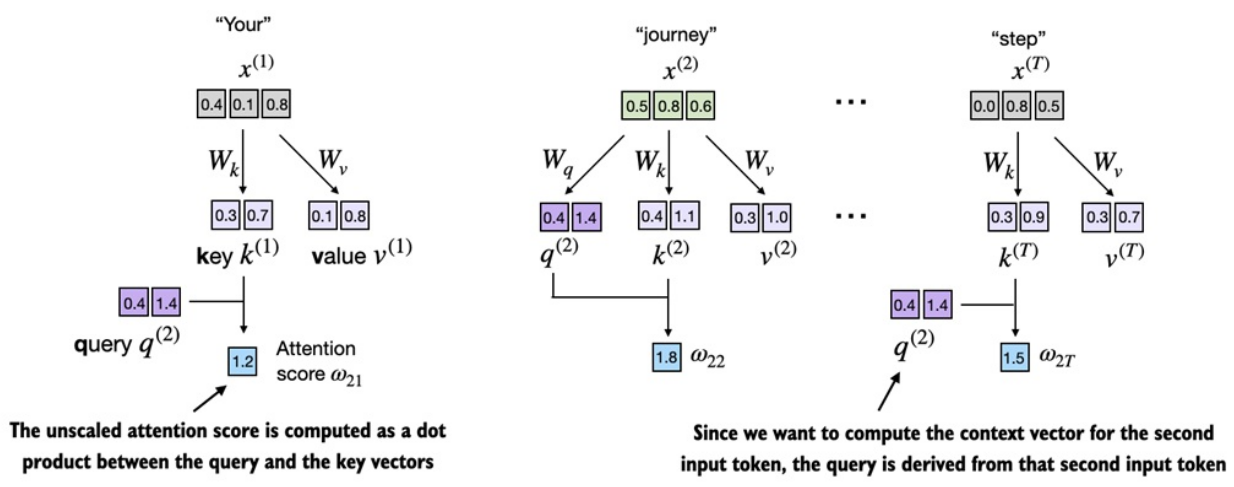

In [ ]:
# First, let's compute the attention score ω22:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

In [ ]:
# Again, we can generalize this computation to all attention scores via matrix multiplication:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

Now going from the attention scores to the attention weights

After computing the attention scores ω, the next step is to normalize these scores
using the softmax function to obtain the attention weights α.

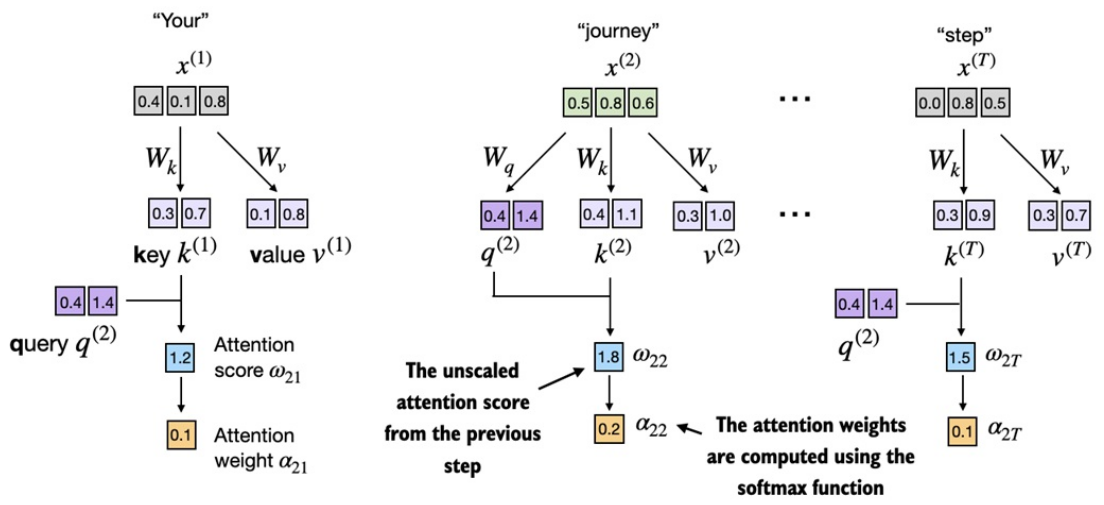

Next, we compute the attention weights by
scaling the attention scores and using the softmax function we used earlier..
The difference to earlier is that we now scale the attention scores by dividing
them by the square root of the embedding dimension of the keys, (note that
taking the square root is mathematically the same as exponentiating by 0.5):

Why: The rapid growth of the exponential function means that large values in the softmax function result in very sharp, binary-like outputs. This behavior emphasizes the importance of scaling scores to maintain a balanced and stable probability distribution, ensuring that the model can learn effectively without becoming overly confident in any single prediction.

In [ ]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

The reason for the normalization by the embedding dimension size is to
improve the training performance by avoiding small gradients. For instance,
when scaling up the embedding dimension, which is typically greater than
thousand for GPT-like LLMs, large dot products can result in very small
gradients during backpropagation due to the softmax function applied to
them. As dot products increase, the softmax function behaves more like a
step function, resulting in gradients nearing zero. These small gradients can
drastically slow down learning or cause training to stagnate.

The scaling by the square root of the embedding dimension is the reason why
this self-attention mechanism is also called scaled-dot product attention.

In the final step of the self-attention computation, we compute the context vector by
combining all value vectors via the attention weights.

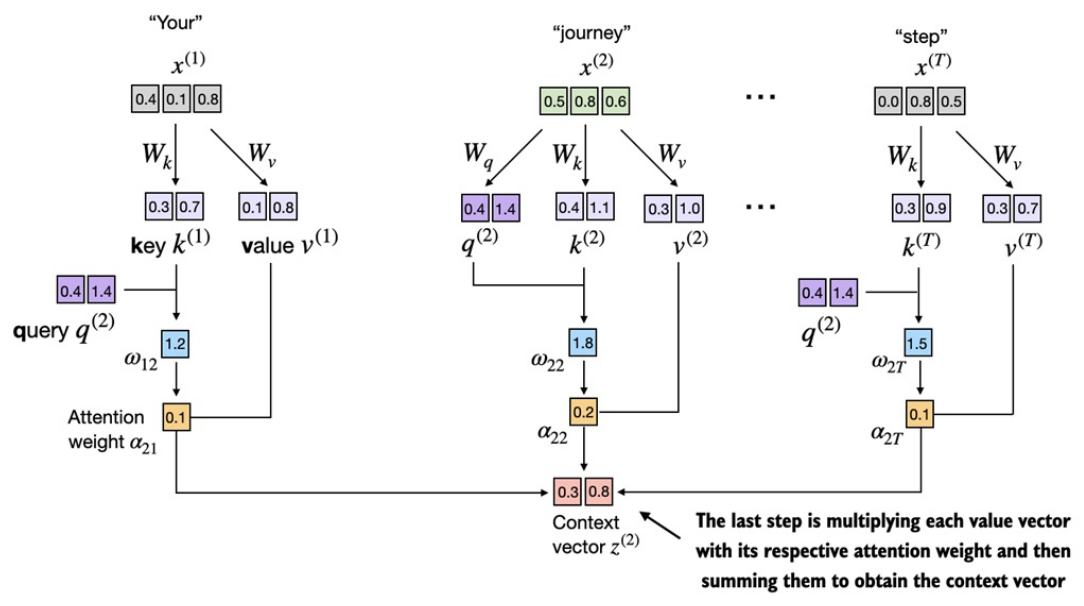

We now compute the context vector as a weighted
sum over the value vectors. Here, the attention weights serve as a weighting
factor that weighs the respective importance of each value vector.

In [ ]:
# we can use matrix multiplication to obtain the output in one step:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

So far, we only computed a single context vector, z(2). In the next section, we
will generalize the code to compute all context vectors in the input sequence,
z(1) to z(T).